# Plotting (Data Visualization)
_To answer our initial questions and prove hypothesis, we visualize our data to have a closer look in different aspects._

**Questions:**
1. How is the overall satisfaction of the employees?

2. How is the overall satisfaction of the employees affected by the service level of core departments?

3. Has the company location an impact on employee satisfaction?

4. Why do the employees contact different departments?



In [38]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
%matplotlib inline

sns.set_palette('PiYG')

#pd.set_option("display.max_columns",100)
#pd.set_option("display.max_rows",100)

df = pd.read_csv('employee_satisfaction.csv')
df.head()

,ID,location,gender,age_category,seniority_category,satisfaction_score,#contact_acct,rating_acct,#contact_HR,rating_HR,#contact_OM,rating_OM,rating_security,rating_D&R
0,1,Boston,Female,2.0,3.0,8.0,1 to 2 times,3.0,3 to 4 times,6.0,1 to 2 times,1.0,4.0,NaN
1,2,Amsterdam,Male,3.0,3.0,10.0,0 times,NaN,1 to 2 times,7.0,5 times or more,10.0,9.0,8.0
2,3,New Dehli,Female,1.0,3.0,8.0,1 to 2 times,8.0,0 times,NaN,5 times or more,10.0,8.0,NaN
3,4,New Dehli,Female,1.0,1.0,7.0,5 times or more,9.0,1 to 2 times,7.0,1 to 2 times,9.0,NaN,NaN
4,5,New Dehli,Female,3.0,4.0,5.0,3 to 4 times,9.0,3 to 4 times,8.0,1 to 2 times,8.0,9.0,NaN


### Q1: How is the overall satisfaction of the employees?

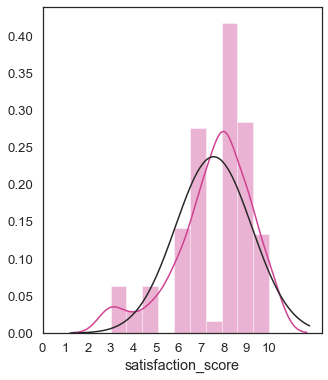

In [39]:
# Let's check out the distribution of satisfaction score among employees
df['satisfaction_score'] = df['satisfaction_score'].fillna(df['satisfaction_score'].mean())

fig, ax = plt.subplots(figsize=(5,6))
sns.distplot(df['satisfaction_score'],fit=stats.norm); 
plt.xticks(range(0,11));

Oberservation:
- Over half of the employee in general are satisfied.


### Q2. : How is the overall satisfaction of the employees affected by the service level of core departments? 

1. By checking looking the correlations and correlation cooefficient, we will find out **whether** and **how much** the overall satisfaction and individual satisfaction for each deparment are affecting each other. 

2. By running linear regression analysis, we try to find out **how** these two factors affect each other.  

##### 1. Heatmap 

In [3]:
# Add columns and convert catogorical data to numeric values for plotting 
# create copies of '#contact' columns and fill them with dummy values to be able to include them in correlation:
df['#contact_acct_num'] = df['#contact_acct'].copy()
df['#contact_HR_num'] = df['#contact_HR'].copy()
df['#contact_OM_num'] = df['#contact_OM'].copy()

In [4]:
df = df.replace({"#contact_acct_num" : {"0 times" : 1, "1 to 2 times" : 2, "3 to 4 times" : 3, "5 times or more" : 4},
                 "#contact_HR_num" : {"0 times" : 1, "1 to 2 times" : 2, "3 to 4 times" : 3, "5 times or more" : 4},
                 "#contact_OM_num" : {"0 times" : 1, "1 to 2 times" : 2, "3 to 4 times" : 3, "5 times or more" : 4}})

In [5]:
df.head()

,ID,location,gender,age_category,seniority_category,satisfaction_score,#contact_acct,rating_acct,#contact_HR,rating_HR,#contact_OM,rating_OM,rating_security,rating_D&R,#contact_acct_num,#contact_HR_num,#contact_OM_num
0,1,Boston,Female,2.0,3.0,8.0,1 to 2 times,3.0,3 to 4 times,6.0,1 to 2 times,1.0,4.0,NaN,2,3,2
1,2,Amsterdam,Male,3.0,3.0,10.0,0 times,NaN,1 to 2 times,7.0,5 times or more,10.0,9.0,8.0,1,2,4
2,3,New Dehli,Female,1.0,3.0,8.0,1 to 2 times,8.0,0 times,NaN,5 times or more,10.0,8.0,NaN,2,1,4
3,4,New Dehli,Female,1.0,1.0,7.0,5 times or more,9.0,1 to 2 times,7.0,1 to 2 times,9.0,NaN,NaN,4,2,2
4,5,New Dehli,Female,3.0,4.0,5.0,3 to 4 times,9.0,3 to 4 times,8.0,1 to 2 times,8.0,9.0,NaN,3,3,2


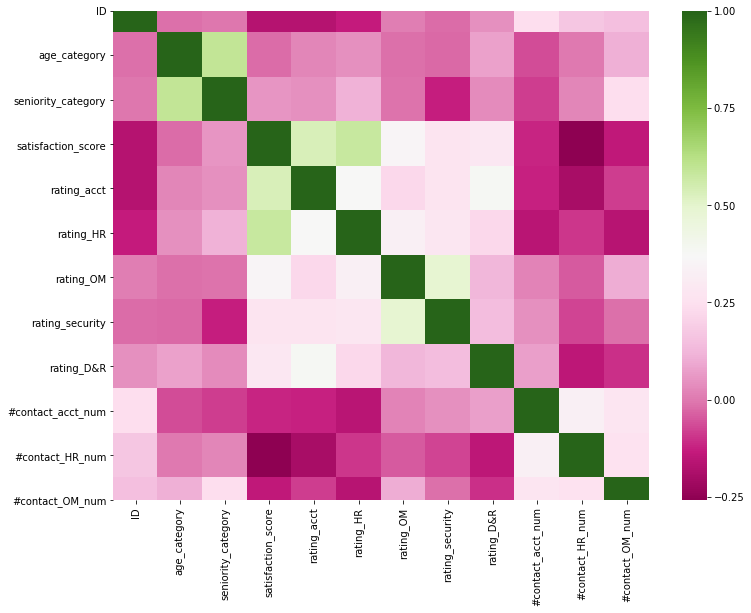

In [6]:
# Plotting heat map to find out correlations across all fields
df_corr = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr, vmax=1, cmap="PiYG");

**Oberservations:**
1. Seniority and age are positively highly correlated 
2. Satisfaction_score are more correltated with rating for Accounting and HR than rating for office management. 

In [7]:
# Look into actual correlation coefficient, the overall correlations are indeed not so strong
df_copy = df.copy()
df_corr_sat = df_copy.corrwith(df['satisfaction_score'])
df_corr_sat.sort_values(ascending=False)

satisfaction_score    1.000000
rating_HR             0.581050
rating_acct           0.535231
rating_OM             0.353352
rating_D&R            0.283559
rating_security       0.267687
seniority_category    0.052012
age_category         -0.017252
#contact_acct_num    -0.116864
#contact_OM_num      -0.144111
ID                   -0.167401
#contact_HR_num      -0.257689
dtype: float64

#### 2. OLS Regression Model 

In [8]:
# To start with, check and handle missing value 
df_copy.isnull().sum()

ID                      0
location                0
gender                  0
age_category            0
seniority_category      0
satisfaction_score      0
#contact_acct           0
rating_acct            10
#contact_HR             0
rating_HR              14
#contact_OM             0
rating_OM              13
rating_security         9
rating_D&R            117
#contact_acct_num       0
#contact_HR_num         0
#contact_OM_num         0
dtype: int64

In [9]:
# Drop rating for data and records since it contains a lot of missing values. 
# Drop also missing values in the rows that represent employees who had never visited major departments 
# in the past year and hence no rating provided
df_copy.drop(['rating_D&R'], axis=1)
df_copy = df_copy.dropna()
df_copy

,ID,location,gender,age_category,seniority_category,satisfaction_score,#contact_acct,rating_acct,#contact_HR,rating_HR,#contact_OM,rating_OM,rating_security,rating_D&R,#contact_acct_num,#contact_HR_num,#contact_OM_num
6,7,New Dehli,Female,1.0,3.0,10.0,5 times or more,8.0,5 times or more,9.0,5 times or more,10.0,10.0,10.0,4,4,4
8,9,Boston,Male,2.0,1.0,8.0,3 to 4 times,8.0,3 to 4 times,10.0,1 to 2 times,9.0,8.0,8.0,3,3,2
17,18,New Dehli,Female,1.0,3.0,8.0,5 times or more,9.0,5 times or more,10.0,5 times or more,10.0,8.0,9.0,4,4,4
21,22,Amsterdam,Male,2.0,2.0,7.0,3 to 4 times,8.0,3 to 4 times,9.0,1 to 2 times,7.0,8.0,8.0,3,3,2
24,25,Boston,Male,3.0,4.0,3.0,1 to 2 times,5.0,5 times or more,3.0,5 times or more,6.0,8.0,4.0,2,4,4
25,26,Boston,Female,1.0,3.0,9.0,1 to 2 times,10.0,5 times or more,10.0,5 times or more,10.0,10.0,1.0,2,4,4
34,35,Boston,Female,1.0,2.0,8.0,3 to 4 times,9.0,5 times or more,9.0,5 times or more,9.0,9.0,6.0,3,4,4
35,36,Amsterdam,Female,3.0,4.0,9.0,1 to 2 times,9.0,5 times or more,9.0,5 times or more,10.0,10.0,10.0,2,4,4
39,40,Amsterdam,Female,2.0,2.0,8.0,3 to 4 times,9.0,3 to 4 times,7.0,3 to 4 times,9.0,9.0,8.0,3,3,3
46,47,Amsterdam,Male,4.0,4.0,8.0,1 to 2 times,7.0,3 to 4 times,8.0,5 times or more,9.0,9.0,8.0,2,3,4


Take a closer look at correlation between 'satisfaction_score' and 'rating_HR' as well as 'rating_acct':

In [10]:
# add constant column to df_copy:
df_copy = sm.add_constant(df_copy)

# run OLS on 'satisfaction_score':
sat_score = sm.OLS(df_copy["satisfaction_score"],
                   df_copy[["const",
                            "rating_HR",
                            "rating_acct",
                            "rating_OM",
                            "#contact_OM_num"]]).fit()

print('Parameters:' ,"\n", sat_score.params, "\n")

print('R2: ', sat_score.rsquared)

Parameters: 
 const             -0.482494
rating_HR          0.458077
rating_acct        0.293074
rating_OM          0.277812
#contact_OM_num   -0.077719
dtype: float64 

R2:  0.5869107276648253


/Users/ivyip/miniconda3/envs/ironhack/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [11]:
sat_score.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     satisfaction_score   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     17.40
Date:                Thu, 21 Nov 2019   Prob (F-statistic):           6.03e-09
Time:                        15:50:07   Log-Likelihood:                -83.170
No. Observations:                  54   AIC:                             176.3
Df Residuals:                      49   BIC:                             186.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4825      1.454     -0.332      0.741      -3.403       2.438
rating_HR           0.4581      0.128      3.572      0.001       0.200       0.716
rating_acct         0.2931      0.105      2.803      0.007       0.083       0.503
rating_OM           0.2778      0.134      2.067      0.044       0.008       0.548
#contact_OM_num    -0.0777      0.239     -0.325      0.747      -0.559       0.404
==============================================================================
Omnibus:                        1.660   Durbin-Watson:                   2.335
Prob(Omnibus):                  0.436   Jarque-Bera (JB):                0.882
Skew:                           0.125   Prob(JB):                        0.643
Kurtosis:                       3.575   Cond. No.                         134.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Observations:

**For 3 out of 4 variables, there is enough statistical evidence to reject the null hypothesis,
as their p-value is below 5%.**

    For:

    • Human Resources Rating ("rating_HR"),
    • Accounting Rating ("rating_acct"),
    • Office Management Rating ("rating_OM")

    there is statistically enough evidence that they are related to the satisfaction score.
    
    -----------------------------------------------------------------------------------------

    For:

    • The number of times employees contacted the Office Management("#contact_OM_num")

    there is statistically not enough evidence that it is related to the satisfaction score.

## Q3. Has the company location an impact on employee satisfaction?

We look closer with the following angles: 
1. Compare the satisfaction score and department ratings among the three locations
2. Compare the number of contacts between employees and departments last year among the three locations  

In [12]:
df_plot1 = (df.groupby(["location", "gender"])
       .agg({'satisfaction_score': 'mean',
             'rating_HR': 'mean',
             'rating_acct': 'mean',
             'rating_OM': 'mean',
             'rating_security': 'mean',
             'rating_D&R': 'mean'}).reset_index())

In [28]:
def plot_by_col( col):
    
    df_plot = (df.groupby(col)
       .agg({'satisfaction_score': 'mean',
             'rating_HR': 'mean',
             'rating_acct': 'mean',
             'rating_OM': 'mean',
             'rating_security': 'mean',
             'rating_D&R': 'mean'}).reset_index())
    
    fig = go.Figure()

    fig.add_trace(
        go.Bar(
            x=df_plot[col],
            y=df_plot['satisfaction_score'],
            name='Satisfaction_Score',
            marker_color='lightgreen'))
    
    fig.add_trace(
        go.Bar(
            x=df_plot[col],
            y=df_plot['rating_acct'],
            name="Rating_Accouting",
            marker_color='green'))
    
    fig.add_trace(
        go.Bar(
            x=df_plot[col],
            y=df_plot['rating_HR'],
            name= "Rating_HR",
            marker_color='darkgreen'))

    fig.add_trace(
        go.Bar(
            x=df_plot[col],
            y=df_plot['rating_OM'],
            name= "Rating_OM",
            marker_color='lightslategrey'
        ))

    fig.show()
    
list_cols = ['location', 'gender', 'age_category', 'seniority_category']
for i in list_cols:
    plot_by_col(i)

Oberservations:

In [14]:
# Compare ratings of departments in each location with a Radar Chart
loc_mean = df.groupby('location').mean().reset_index()
loc_mean

,location,ID,age_category,seniority_category,satisfaction_score,rating_acct,rating_HR,rating_OM,rating_security,rating_D&R,#contact_acct_num,#contact_HR_num,#contact_OM_num
0,Amsterdam,87.645570,2.367089,2.873418,7.500601,7.666667,8.136986,8.743243,8.883117,8.944444,3.126582,2.924051,3.139241
1,Boston,98.528090,2.202247,2.662921,7.523005,7.771084,7.710843,8.617284,8.602410,7.071429,2.977528,2.898876,3.258427
2,New Dehli,59.846154,1.846154,2.692308,8.000000,8.461538,8.363636,9.538462,8.916667,9.750000,3.230769,2.615385,3.384615


In [15]:
fig = go.Figure()

data = [go.Scatterpolar(
        name = loc_mean['location'].values[2],
        r = [loc_mean['rating_acct'].values[2],loc_mean['rating_HR'].values[2], 
             loc_mean['rating_OM'].values[2],loc_mean['rating_security'].values[2], loc_mean['rating_D&R'].values[2]],
        theta = ['Accounting','HR','Office Management','Security','Data & Records'],
        fill = 'toself',
        line =  dict(color = 'pink')),
        
        go.Scatterpolar(
        name = loc_mean['location'].values[0],
        r = [loc_mean['rating_acct'].values[0],loc_mean['rating_HR'].values[0],
             loc_mean['rating_OM'].values[0],loc_mean['rating_security'].values[0],loc_mean['rating_D&R'].values[0]],
        theta = ['Accounting','HR','Office Management','Security','Data & Records'],
        fill = 'toself',
        line =  dict(color = 'lightgreen')),
       
        go.Scatterpolar(
        name = loc_mean['location'].values[1],
        r = [loc_mean['rating_acct'].values[1],loc_mean['rating_HR'].values[1], 
             loc_mean['rating_OM'].values[1],loc_mean['rating_security'].values[1], loc_mean['rating_D&R'].values[1]],
        theta = ['Accounting','HR','Office Management','Security','Data & Records'],
        fill = 'toself',
        line =  dict(color = 'darkgreen'))]
       
layout = go.Layout(polar = dict(radialaxis = dict(visible = True, range = [1,10])),
                   showlegend = True,
                   title = "Rating of each departments among locations")

go.Figure(data=data,layout=layout)

##### Q3. 2 Compare # contacts among locations

**Barplot: Accounting Department**

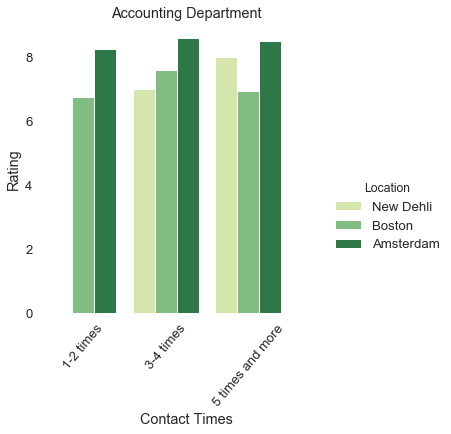

In [27]:
accounting = sns.catplot(x='#contact_acct_num', y='rating_acct',hue="location", kind= "bar", 
                         data=df_copy, palette=("YlGn"), ci=None)

sns.set(font_scale=1.2)

plt.xticks([0,1,2,3])
accounting.set_xticklabels(['1-2 times','3-4 times','5 times and more'],rotation=50)
plt.title('Accounting Department')
plt.xlabel('Contact Times')
plt.ylabel('Rating')
accounting._legend.set_title("Location")
sns.despine(left=True, bottom=True)
sns.set_style("white")

**Barplot: HR Department**

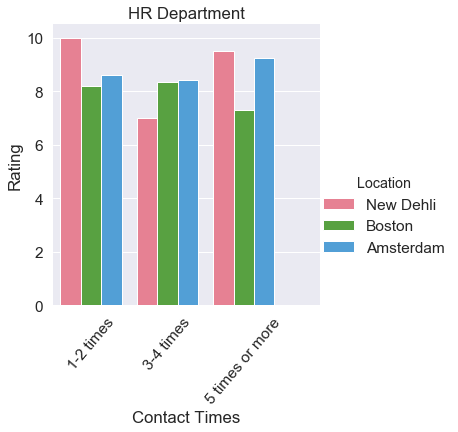

In [18]:
hr = sns.catplot(x='#contact_HR_num', y='rating_HR',hue="location", kind= "bar", data=df_copy, palette=("husl"), ci=None)

plt.xticks([0,1,2,3,4])
hr.set_xticklabels(['0 times','1-2 times','3-4 times','5 times or more'],rotation=50)
plt.xlim(0.5, 4)
plt.title('HR Department')
plt.xlabel('Contact Times')
plt.ylabel('Rating')
hr._legend.set_title("Location")
sns.despine(left=True, bottom=True)
sns.set_style("white");

**Barplot: Office Management Department**

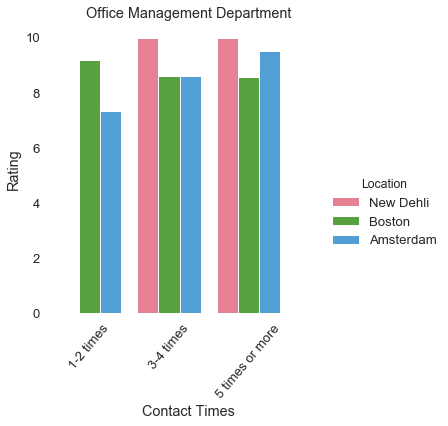

In [29]:
om = sns.catplot(x='#contact_OM_num', y='rating_OM', hue="location", kind= "bar", data=df_copy, palette=("husl"),ci=None)

plt.xticks([0,1,2,3])
om.set_xticklabels(['1-2 times','3-4 times','5 times or more'],rotation=50)
plt.title('Office Management Department')
plt.xlabel('Contact Times')
plt.ylabel('Rating')
om._legend.set_title("Location")
sns.despine(left=True, bottom=True)
sns.set_style("white");

**Barplot: Satisfaction by Gender & Location**

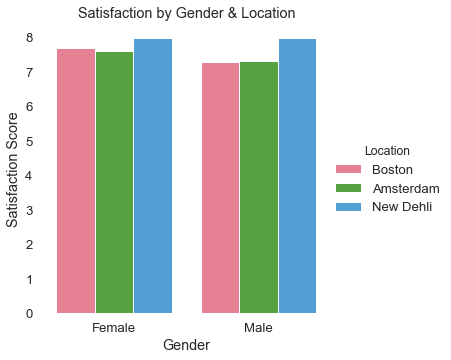

In [30]:
sat_gender_loc = sns.catplot(x="gender", y="satisfaction_score", hue="location", kind="bar", data=df, palette=("husl"), ci=None)

plt.title('Satisfaction by Gender & Location')
plt.xlabel('Gender')
plt.ylabel('Satisfaction Score')
sat_gender_loc._legend.set_title("Location")
sns.despine(left=True, bottom=True)
sns.set_style("white");

### *Other plots*

In [41]:
# Gender diversity of three locations
fig = px.bar(data_frame= df,
     x = "location",
     y = "satisfaction_score",
     color = "gender",
     barmode="group")
fig.show()

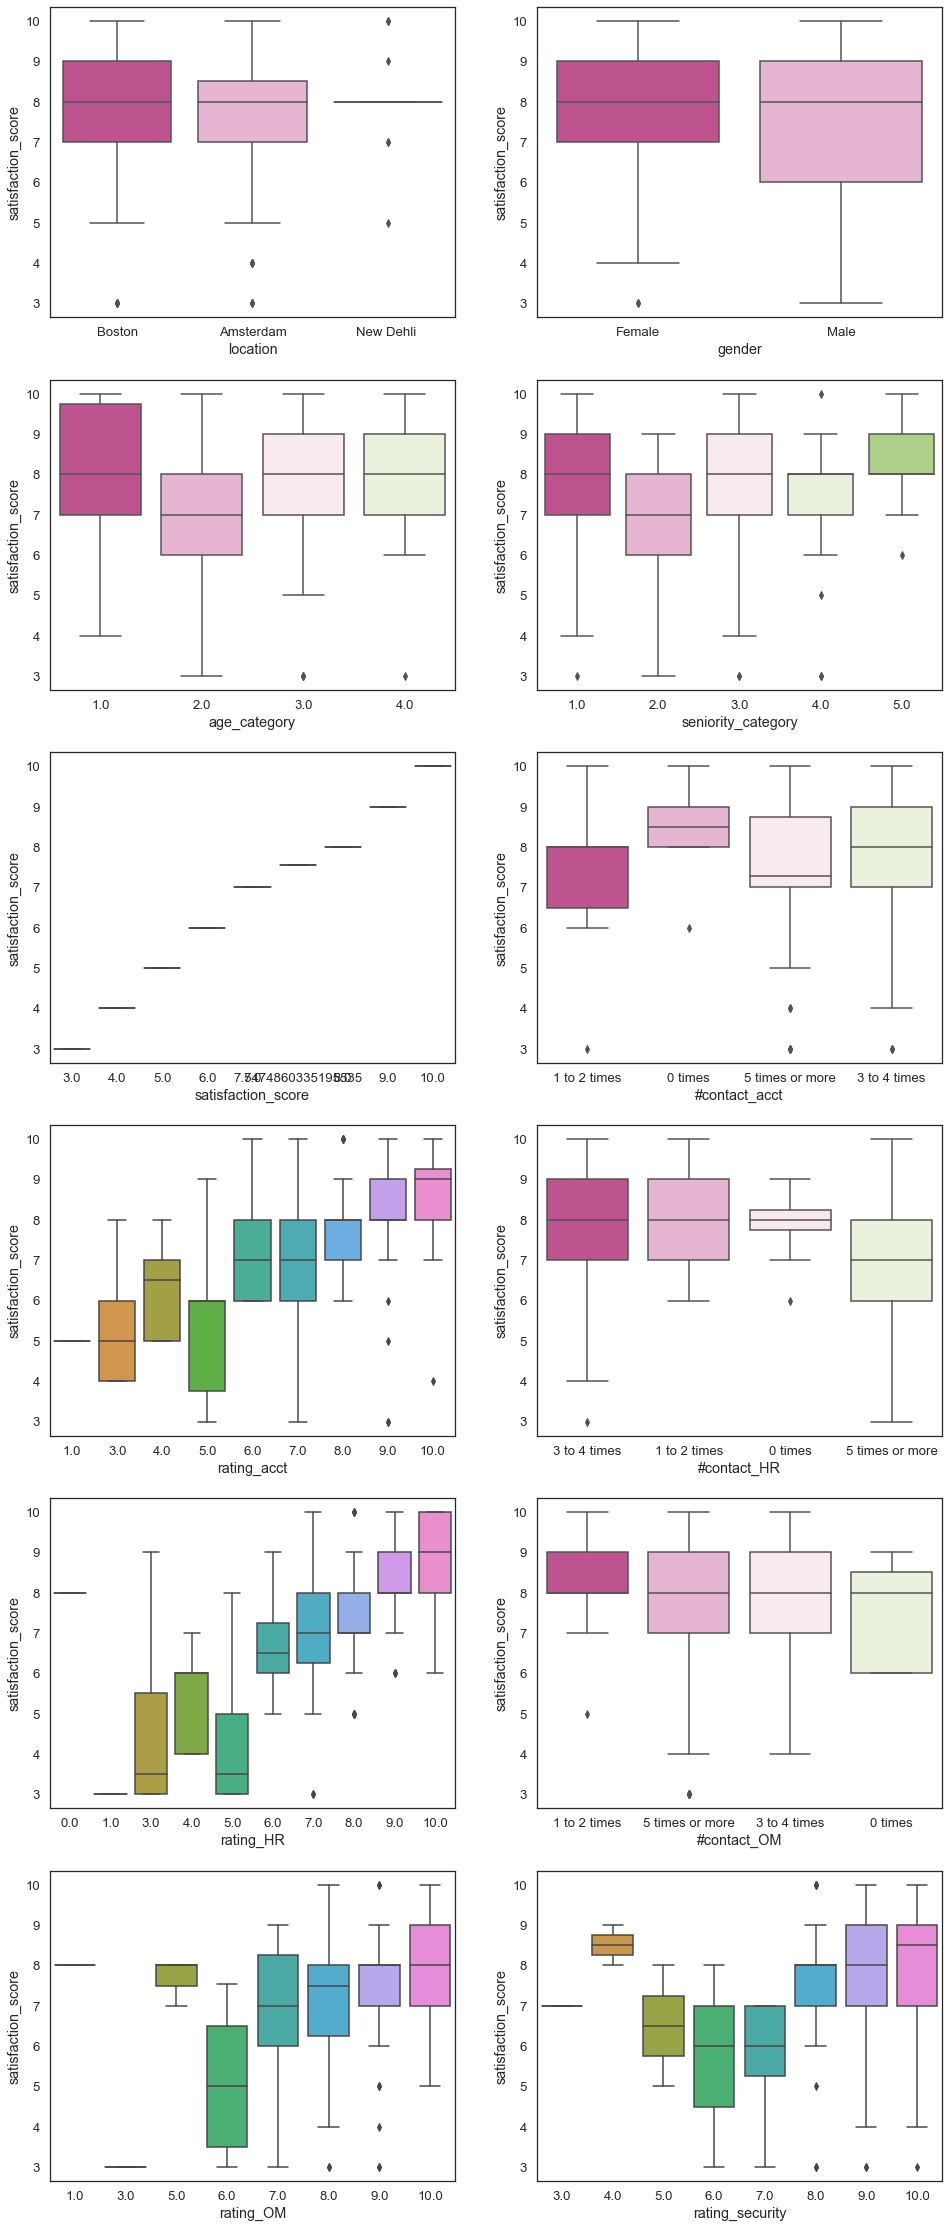

In [43]:
# Boxplots for each independent variables vs target (dependent) variable

df_cols = list(df.columns[1:])

fig, ax = plt.subplots (nrows=6,ncols=2,figsize = (16,40))

i=0
for row in range(0,6):
    for col in range(0,2):
        sns.boxplot(data=df, x=df_cols[i], y='satisfaction_score', ax=ax[row,col]);
        i+=1

In [45]:
lat = {'Amsterdam' : 52.371807,
       'Boston' : 42.361145,
       'New Dehli ' : 28.644800}

lon = {'Amsterdam' : 4.896029,
       'Boston' : -71.057083,
       'New Dehli ' : 77.216721}

geo = (df.groupby('location').count()).reset_index()
geo['lat'] = geo['location'].map(lat)
geo['lon'] = geo['location'].map(lon)
geo = geo.rename({'ID':'num_employee'},axis=1)
geo

,location,num_employee,gender,age_category,seniority_category,satisfaction_score,#contact_acct,rating_acct,#contact_HR,rating_HR,#contact_OM,rating_OM,rating_security,rating_D&R,lat,lon
0,Amsterdam,79,79,79,79,79,79,75,79,73,79,74,77,18,52.371807,4.896029
1,Boston,89,89,89,89,89,89,83,89,83,89,81,83,42,42.361145,-71.057083
2,New Dehli,13,13,13,13,13,13,13,13,11,13,13,12,4,28.644800,77.216721


In [ ]:
# Company location and size on map 
fig = px.scatter_geo(
        lon = geo['lon'],
        lat = geo['lat'],
        size = geo['num_employee'],
        color = geo['location'])

fig.update_layout(
        title = 'Company location and size')

fig.show()